<a href="https://colab.research.google.com/github/berniwal/CIL_Project/blob/master/CIL-Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Go to correct directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.getcwd()
os.chdir('/content/drive/My Drive/CIL/CIL_Project/CIL')
os.getcwd()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


'/content/drive/My Drive/CIL/CIL_Project/CIL'

## install + import libraries

In [7]:
!pip install params_flow==0.7.1
!pip install py-params==0.7.3
!pip install sentencepiece
#!pip install bert-for-tf2
import sentencepiece as spm
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
from datetime import datetime

import bert
#different Tokenizer for Albert
#from bert.tokenization.bert_tokenization import FullTokenizer
from bert.tokenization.albert_tokenization import AlbertFullTokenizer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert import BertModelLayer
import sentencepiece as spm

from tqdm import tqdm
import numpy as np

from sklearn.utils import shuffle

Tensorflow version 2.2.0
Running on TPU  ['10.22.97.2:8470']


## Fix Directories for BERT
First part of selecting which model

In [3]:
# 'bert' or 'bert_large' or 'albert'
MODEL = 'albert'
ADDITIONAL_DATA = False
identifier='_base' # for naming the output csv, weights and validation scores for graph

# '' or '_monoise' or '_monoise_b'
DATASET_PREPROCESSING = '' 

#Learning parameters
epochs = 40
last_val_loss = None
patience = 5
no_improvement_since = 0
current_learning_rate = 1e-5
minimum_learning_rate = 1e-7
# TODO: change back
reload_training = False
reload_checkpoint = './albert_base.h5'

CHECKPOINT = None
CHECKPOINT_CKPT = None
CHECKPOINT_VOCAB = None
CHECKPOINT_CONFIG = None

if MODEL == 'bert':
  CHECKPOINT = './bert/checkpoints/bert_base'
if MODEL == 'bert_large':
  CHECKPOINT = './bert/checkpoints/bert_large_wwm'
if MODEL == 'albert':
  CHECKPOINT = './bert/checkpoints/albert_base'

if MODEL == 'bert' or MODEL == 'bert_large':
  CHECKPOINT_CKPT = os.path.join(CHECKPOINT, 'bert_model.ckpt')
  CHECKPOINT_VOCAB = os.path.join(CHECKPOINT, 'vocab.txt')
  CHECKPOINT_CONFIG = os.path.join(CHECKPOINT, 'bert_config.json')
if MODEL == 'albert':
  CHECKPOINT_VOCAB = os.path.join(CHECKPOINT, '30k-clean.model')
  CHECKPOINT_CKPT = os.path.join(CHECKPOINT, 'model.ckpt-best')
  CHECKPOINT_CONFIG = os.path.join(CHECKPOINT, 'albert_config.json')

DATASET_DIR = './'
DATASET_FILE_TRAIN_NEG = os.path.join(DATASET_DIR, 'twitter-datasets/train_neg_full{}.txt'.format(DATASET_PREPROCESSING))
DATASET_FILE_TRAIN_POS = os.path.join(DATASET_DIR, 'twitter-datasets/train_pos_full{}.txt'.format(DATASET_PREPROCESSING))
DATASET_FILE_TEST = os.path.join(DATASET_DIR, 'twitter-datasets/test_data{}.txt'.format(DATASET_PREPROCESSING))

DATASET_FILE_NEG_EXTRA = os.path.join(DATASET_DIR, 'twitter-datasets/extra_neg{}.txt'.format(DATASET_PREPROCESSING))
DATASET_FILE_POS_EXTRA = os.path.join(DATASET_DIR, 'twitter-datasets/extra_pos{}.txt'.format(DATASET_PREPROCESSING))

FILE_PATHS = [DATASET_FILE_TRAIN_POS, DATASET_FILE_TRAIN_NEG]

steps = None
if ADDITIONAL_DATA:
  steps = 336
else:
  steps = 200

## methods to create BERT layer
change name="albert" for other model, have to adjust paths above too

In [4]:
def flatten_layers(root_layer):
    if isinstance(root_layer, keras.layers.Layer):
        yield root_layer
    for layer in root_layer._layers:
        for sub_layer in flatten_layers(layer):
            yield sub_layer


def freeze_bert_layers(l_bert):
    """
    Freezes all but LayerNorm and adapter layers - see arXiv:1902.00751.
    """
    for layer in flatten_layers(l_bert):
        if layer.name in ["LayerNorm", "adapter-down", "adapter-up"]:
            layer.trainable = True
        elif len(layer._layers) == 0:
            layer.trainable = False
        l_bert.embeddings_layer.trainable = False


def create_learning_rate(learn_rate=5e-5):

    def lr_scheduler(epoch):
        return float(learn_rate)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler

def create_learning_rate_scheduler(max_learn_rate=5e-5,
                                   end_learn_rate=1e-7,
                                   warmup_epoch_count=10,
                                   total_epoch_count=90):

    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            #res = (max_learn_rate/warmup_epoch_count) * (epoch + 1)
            res = end_learn_rate
        else:
            res = max_learn_rate*math.exp(math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler


def create_model(max_seq_len, adapter_size=64):
    """Creates a classification model."""

    # adapter_size = 64  # see - arXiv:1902.00751

    # create the bert layer
    with tf.io.gfile.GFile(CHECKPOINT_CONFIG, "r") as reader:
        #Download from Google
        #model_dir    = bert.fetch_tfhub_albert_model(model_name, ".models")
        #bert_params = bert.albert_params(model_name)
        #bert_l = BertModelLayer.from_params(bert_params, name="albert", shared_layer=True, embedding_size=128)
        
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = adapter_size
        bert_l = None
        if MODEL[:4] == 'bert':
          bert_l = BertModelLayer.from_params(bert_params, name="bert")
        else:
          bert_l = BertModelLayer.from_params(bert_params, name="albert", shared_layer=True, embedding_size=128)

    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
    # token_type_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="token_type_ids")
    # output         = bert([input_ids, token_type_ids])
    output = bert_l(input_ids)

    print("bert shape", output.shape)
    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=2, activation="softmax")(logits)

    # model = keras.Model(inputs=[input_ids, token_type_ids], outputs=logits)
    # model.build(input_shape=[(None, max_seq_len), (None, max_seq_len)])
    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    # load the pre-trained model weights
    if MODEL[:4] == 'bert':
      load_stock_weights(bert_l, CHECKPOINT_CKPT)
    else:
      bert.load_albert_weights(bert_l, CHECKPOINT_CKPT)

    # freeze weights if adapter-BERT is used
    if adapter_size is not None:
        freeze_bert_layers(bert_l)

    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

    return model

# Define Dataloading Class
Also loading data into array


In [8]:
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

def load_data(file_path):
    data = {}
    data["sentence"] = []
    with open(file_path, "r") as f:
        data["sentence"] = f.readlines()

    #longest_string = max(data["sentence"], key=len)
    #print(longest_string)
    #print(len(longest_string))

    return pd.DataFrame.from_dict(data)

def load_dataset(pos_directory, neg_directory):
    pos_df = load_data(pos_directory)
    neg_df = load_data(neg_directory)

    pos_df["sentiment"] = 1
    neg_df["sentiment"] = 0

    return pd.concat([pos_df, neg_df])

class MovieReviewData:
    DATA_COLUMN = "sentence"
    LABEL_COLUMN = "sentiment"

    def __init__(self, tokenizer= FullTokenizer, max_seq_len=128, steps=200, extra_data=False):
        self.tokenizer = tokenizer
        self.step = None
        self.sample_size= 128*937
        self.max_seq_len = max_seq_len
        self.train_x = None
        self.train_x_token_types = None
        self.test_x = None
        self.test_x_token_types = None
        self.train_y = None
        self.test_y = None
        self.steps = steps
        self.extra_data = extra_data
        
    def _prepare(self, df):
        x, y = [], []
        with tqdm(total=df.shape[0], unit_scale=True) as pbar:
            for ndx, row in df.iterrows():
                text, label = row[MovieReviewData.DATA_COLUMN], row[MovieReviewData.LABEL_COLUMN]
                tokens = self.tokenizer.tokenize(text)
                tokens = ["[CLS]"] + tokens + ["[SEP]"]
                token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
                # self.max_seq_len = max(self.max_seq_len, len(token_ids))
                x.append(token_ids)
                y.append(int(label))
                pbar.update()
        return np.array(x), np.array(y)

    def _pad(self, ids):
        x, t = [], []
        token_type_ids = [0] * self.max_seq_len
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
            t.append(token_type_ids)
        return np.array(x), np.array(t)

    def load_data(self, step, update_test=True):
        trainset = load_dataset(DATASET_FILE_TRAIN_POS, DATASET_FILE_TRAIN_NEG)

        step = step % self.steps

        trainset = shuffle(trainset, random_state=5)
        #remove already processed data
        train = trainset.head(2400000)

        if self.extra_data:
          trainset_extra = load_dataset(DATASET_FILE_POS_EXTRA, DATASET_FILE_NEG_EXTRA)
          trainset_extra = shuffle(trainset_extra, random_state=5)
          train = pd.concat([train, trainset_extra], ignore_index=True)
        
        train = train.head(self.steps*128*93)
        train = train.tail(self.steps*128*93 - step*128*93)
        train = train.head(128*93)
        test = trainset.tail(100000)
        #train = trainset.head(10*128)
        #test = trainset.tail(10*128)

        train = shuffle(train)
        test = shuffle(test)

        train.reset_index(inplace=True, drop=True)
        test.reset_index(inplace=True, drop=True)

        if update_test:
          ((self.train_x, self.train_y),
          (self.test_x, self.test_y)) = map(self._prepare, [train, test])

          ((self.train_x, self.train_x_token_types),
          (self.test_x, self.test_x_token_types)) = map(self._pad,
                                                        [self.train_x, self.test_x])
        else:
          df_empty = pd.DataFrame({'empty' : []})
          ((self.train_x, self.train_y),
          (_, _)) = map(self._prepare, [train, df_empty])

          ((self.train_x, self.train_x_token_types),
          (_, _)) = map(self._pad, [self.train_x, []])

spm_model = None
sp = None

if MODEL == 'albert':
  spm_model = os.path.join('./bert/checkpoints/albert_base/', "30k-clean.model")
  sp = spm.SentencePieceProcessor()
  sp.load(spm_model)

tokenizer = None
if MODEL[:4] == 'bert':
  tokenizer = FullTokenizer(vocab_file=CHECKPOINT_VOCAB, do_lower_case=True)
else:
  tokenizer = AlbertFullTokenizer(vocab_file=None, do_lower_case=True, spm_model_file=CHECKPOINT_VOCAB)

## BERT text preprocessing

In [9]:
def pre_process_positive(x, max_seq_len):
  tokens = tokenizer.tokenize(x.numpy())
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  token_ids = token_ids[:min(len(token_ids), max_seq_len - 2)]
  token_ids = np.concatenate((token_ids, np.zeros((max_seq_len - len(token_ids))))).astype(np.int32)
  return token_ids, int(1)

def pre_process_negative(x, max_seq_len):
  tokens = tokenizer.tokenize(x.numpy())
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  token_ids = token_ids[:min(len(token_ids), max_seq_len - 2)]
  token_ids = np.concatenate((token_ids, np.zeros((max_seq_len - len(token_ids))))).astype(np.int32)
  return token_ids, int(0)

def pre_process_text(x):
  tokens = tokenizer.tokenize(x.numpy())
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  return tokens

def dummy_pre_process(x):
   return tf.constant(3, shape=(128,))

## Build Model

In [10]:
max_seq_len = 128
adapter_size = None

with tpu_strategy.scope():
    model = create_model(max_seq_len, adapter_size=adapter_size)

model.summary()

total_epoch_count = 1

bert shape (None, 128, 768)
Loading google-research/ALBERT weights...
Done loading 22 BERT weights from: ./bert/checkpoints/albert_base/model.ckpt-best into <bert.model.BertModelLayer object at 0x7f4e5d6b9358> (prefix:albert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
	global_step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_______________________________________________________________


## Train model/fit+save weights

In [11]:
data = MovieReviewData(tokenizer, max_seq_len=128, steps=steps, extra_data=ADDITIONAL_DATA)

val_losses = []
val_accuracy = []
train_losses = []
train_accuracy = []

if reload_training:
  model.load_weights(reload_checkpoint) 

finished_learning = False
update_test = True
for epoch in range(epochs):
  
  for step in range(steps):
    print('Epoch {}/{} Step {}/{}'.format(epoch, epochs-1, step, steps-1))
    print('Loading Data...')
    data.load_data(step, update_test)
    if update_test:
      update_test = False

    dataset_train = tf.data.Dataset.from_tensor_slices((data.train_x, data.train_y))
    dataset_train = dataset_train.batch(32, drop_remainder=True)

    dataset_test = tf.data.Dataset.from_tensor_slices((data.test_x, data.test_y))
    dataset_test = dataset_test.batch(32, drop_remainder=True)

    train_history = model.fit(dataset_train,
                    epochs=1,
                    callbacks=[create_learning_rate(learn_rate=current_learning_rate)])
    
    loss = train_history.history['loss'][0]
    accuracy = train_history.history['acc'][0]

    train_losses.append(loss)
    train_accuracy.append(accuracy)

    if step % 10 == 0:
      print('Run Validation...')
      results = model.evaluate(dataset_test)
      val_loss = results[0]
      val_acc = results[1]
      val_losses.append(val_loss)
      val_accuracy.append(val_acc)

      if last_val_loss is None or last_val_loss > val_loss:
        last_val_loss = val_loss
        no_improvement_since = 0
      else:
        no_improvement_since += 1
        if no_improvement_since >= patience:
          current_learning_rate = current_learning_rate * 0.1
          if current_learning_rate < minimum_learning_rate:
            print('Learning Finished Early')
            finished_learning = True
            break
          print('Decreasing Learning Rate to: {}'.format(current_learning_rate))
          no_improvement_since = 0
        else:
          print('No improvement since: {}'.format(no_improvement_since))


    if step != 0 and step % 100 == 0:
      model.save_weights('./'+MODEL+identifier+'_epoch_{}_step_{}.h5'.format(epoch, step), overwrite=True)

  model.save_weights('./'+MODEL+identifier+'_epoch_{}.h5'.format(epoch), overwrite=True)
  
  # Write Results Intermediate
  if not os.path.exists('./results'):
    os.mkdir('./results')

  f = open('./results/'+MODEL+identifier+'_epoch_{}_train.txt'.format(epoch), 'w')
  for x in range(len(train_losses)):
    f.write('{} {} {}\n'.format(x, train_losses[x], train_accuracy[x]))
  f.close()

  f = open('./results/'+MODEL+identifier+'_epoch_{}_validation.txt'.format(epoch), 'w')
  for x in range(len(val_losses)):
    f.write('{} {} {}\n'.format(x * 100, val_losses[x], val_accuracy[x]))
  f.close()

  if finished_learning: 
    break

model.save_weights('./'+MODEL+identifier+'.h5', overwrite=True)

# Write Results
if not os.path.exists('./results'):
  os.mkdir('./results')

f = open('./results/'+MODEL+identifier+'_train.txt', 'w')
for x in range(len(train_losses)):
  f.write('{} {} {}\n'.format(x, train_losses[x], train_accuracy[x]))
f.close()

f = open('./results/'+MODEL+identifier+'_validation.txt', 'w')
for x in range(len(val_losses)):
  f.write('{} {} {}\n'.format(x * 100, val_losses[x], val_accuracy[x]))
f.close()

Epoch 0/39 Step 0/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.47kit/s]
100%|██████████| 100k/100k [00:22<00:00, 4.44kit/s] 



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.7375 - acc: 0.5123 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.7010 - acc: 0.5000
Epoch 0/39 Step 1/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.7314 - acc: 0.5155 - lr: 1.0000e-05
Epoch 0/39 Step 2/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.7374 - acc: 0.5024 - lr: 1.0000e-05
Epoch 0/39 Step 3/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.6545 - acc: 0.6364 - lr: 1.0000e-05
Epoch 0/39 Step 4/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.6093 - acc: 0.6925 - lr: 1.0000e-05
Epoch 0/39 Step 5/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.51kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.5549 - acc: 0.7548 - lr: 1.0000e-05
Epoch 0/39 Step 6/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.45kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.5287 - acc: 0.7776 - lr: 1.0000e-05
Epoch 0/39 Step 7/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.5107 - acc: 0.7965 - lr: 1.0000e-05
Epoch 0/39 Step 8/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.5132 - acc: 0.7960 - lr: 1.0000e-05
Epoch 0/39 Step 9/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.5088 - acc: 0.7960 - lr: 1.0000e-05
Epoch 0/39 Step 10/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.5078 - acc: 0.7991 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4964 - acc: 0.8106
Epoch 0/39 Step 11/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.5039 - acc: 0.8017 - lr: 1.0000e-05
Epoch 0/39 Step 12/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.20kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.5002 - acc: 0.8061 - lr: 1.0000e-05
Epoch 0/39 Step 13/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.07kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.5002 - acc: 0.8054 - lr: 1.0000e-05
Epoch 0/39 Step 14/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4923 - acc: 0.8168 - lr: 1.0000e-05
Epoch 0/39 Step 15/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4943 - acc: 0.8122 - lr: 1.0000e-05
Epoch 0/39 Step 16/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4959 - acc: 0.8101 - lr: 1.0000e-05
Epoch 0/39 Step 17/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4998 - acc: 0.8083 - lr: 1.0000e-05
Epoch 0/39 Step 18/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.96kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4949 - acc: 0.8128 - lr: 1.0000e-05
Epoch 0/39 Step 19/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4887 - acc: 0.8179 - lr: 1.0000e-05
Epoch 0/39 Step 20/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.45kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.5022 - acc: 0.8067 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4959 - acc: 0.8155
Epoch 0/39 Step 21/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4963 - acc: 0.8100 - lr: 1.0000e-05
Epoch 0/39 Step 22/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4885 - acc: 0.8157 - lr: 1.0000e-05
Epoch 0/39 Step 23/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4821 - acc: 0.8246 - lr: 1.0000e-05
Epoch 0/39 Step 24/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4830 - acc: 0.8244 - lr: 1.0000e-05
Epoch 0/39 Step 25/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 3.99kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4816 - acc: 0.8223 - lr: 1.0000e-05
Epoch 0/39 Step 26/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4813 - acc: 0.8269 - lr: 1.0000e-05
Epoch 0/39 Step 27/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4855 - acc: 0.8217 - lr: 1.0000e-05
Epoch 0/39 Step 28/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4761 - acc: 0.8286 - lr: 1.0000e-05
Epoch 0/39 Step 29/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.47kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4727 - acc: 0.8332 - lr: 1.0000e-05
Epoch 0/39 Step 30/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4782 - acc: 0.8290 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4769 - acc: 0.8308
Epoch 0/39 Step 31/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4790 - acc: 0.8272 - lr: 1.0000e-05
Epoch 0/39 Step 32/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4796 - acc: 0.8273 - lr: 1.0000e-05
Epoch 0/39 Step 33/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4742 - acc: 0.8316 - lr: 1.0000e-05
Epoch 0/39 Step 34/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4773 - acc: 0.8271 - lr: 1.0000e-05
Epoch 0/39 Step 35/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4802 - acc: 0.8253 - lr: 1.0000e-05
Epoch 0/39 Step 36/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4759 - acc: 0.8338 - lr: 1.0000e-05
Epoch 0/39 Step 37/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4826 - acc: 0.8241 - lr: 1.0000e-05
Epoch 0/39 Step 38/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.50kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4805 - acc: 0.8282 - lr: 1.0000e-05
Epoch 0/39 Step 39/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4867 - acc: 0.8217 - lr: 1.0000e-05
Epoch 0/39 Step 40/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4803 - acc: 0.8277 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4901 - acc: 0.8180
No improvement since: 1
Epoch 0/39 Step 41/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4707 - acc: 0.8388 - lr: 1.0000e-05
Epoch 0/39 Step 42/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4762 - acc: 0.8322 - lr: 1.0000e-05
Epoch 0/39 Step 43/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4723 - acc: 0.8336 - lr: 1.0000e-05
Epoch 0/39 Step 44/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4779 - acc: 0.8304 - lr: 1.0000e-05
Epoch 0/39 Step 45/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4771 - acc: 0.8263 - lr: 1.0000e-05
Epoch 0/39 Step 46/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4699 - acc: 0.8365 - lr: 1.0000e-05
Epoch 0/39 Step 47/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4713 - acc: 0.8356 - lr: 1.0000e-05
Epoch 0/39 Step 48/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.13kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4646 - acc: 0.8411 - lr: 1.0000e-05
Epoch 0/39 Step 49/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4692 - acc: 0.8388 - lr: 1.0000e-05
Epoch 0/39 Step 50/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4667 - acc: 0.8424 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4701 - acc: 0.8400
Epoch 0/39 Step 51/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4765 - acc: 0.8322 - lr: 1.0000e-05
Epoch 0/39 Step 52/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4639 - acc: 0.8453 - lr: 1.0000e-05
Epoch 0/39 Step 53/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4675 - acc: 0.8389 - lr: 1.0000e-05
Epoch 0/39 Step 54/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4664 - acc: 0.8402 - lr: 1.0000e-05
Epoch 0/39 Step 55/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4718 - acc: 0.8346 - lr: 1.0000e-05
Epoch 0/39 Step 56/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4642 - acc: 0.8427 - lr: 1.0000e-05
Epoch 0/39 Step 57/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.28kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4630 - acc: 0.8452 - lr: 1.0000e-05
Epoch 0/39 Step 58/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4666 - acc: 0.8428 - lr: 1.0000e-05
Epoch 0/39 Step 59/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4682 - acc: 0.8392 - lr: 1.0000e-05
Epoch 0/39 Step 60/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4596 - acc: 0.8475 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4569 - acc: 0.8491
Epoch 0/39 Step 61/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4609 - acc: 0.8485 - lr: 1.0000e-05
Epoch 0/39 Step 62/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4595 - acc: 0.8454 - lr: 1.0000e-05
Epoch 0/39 Step 63/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4628 - acc: 0.8450 - lr: 1.0000e-05
Epoch 0/39 Step 64/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4617 - acc: 0.8424 - lr: 1.0000e-05
Epoch 0/39 Step 65/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.92kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4684 - acc: 0.8390 - lr: 1.0000e-05
Epoch 0/39 Step 66/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4586 - acc: 0.8469 - lr: 1.0000e-05
Epoch 0/39 Step 67/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4618 - acc: 0.8461 - lr: 1.0000e-05
Epoch 0/39 Step 68/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4597 - acc: 0.8488 - lr: 1.0000e-05
Epoch 0/39 Step 69/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4579 - acc: 0.8477 - lr: 1.0000e-05
Epoch 0/39 Step 70/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.46kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4589 - acc: 0.8480 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4581 - acc: 0.8507
No improvement since: 1
Epoch 0/39 Step 71/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.91kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4650 - acc: 0.8432 - lr: 1.0000e-05
Epoch 0/39 Step 72/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.45kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4563 - acc: 0.8523 - lr: 1.0000e-05
Epoch 0/39 Step 73/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4652 - acc: 0.8417 - lr: 1.0000e-05
Epoch 0/39 Step 74/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.50kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4601 - acc: 0.8462 - lr: 1.0000e-05
Epoch 0/39 Step 75/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.48kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4627 - acc: 0.8438 - lr: 1.0000e-05
Epoch 0/39 Step 76/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4593 - acc: 0.8441 - lr: 1.0000e-05
Epoch 0/39 Step 77/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4555 - acc: 0.8526 - lr: 1.0000e-05
Epoch 0/39 Step 78/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 3.97kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4571 - acc: 0.8487 - lr: 1.0000e-05
Epoch 0/39 Step 79/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.48kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4539 - acc: 0.8521 - lr: 1.0000e-05
Epoch 0/39 Step 80/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4538 - acc: 0.8531 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4567 - acc: 0.8518
Epoch 0/39 Step 81/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4528 - acc: 0.8529 - lr: 1.0000e-05
Epoch 0/39 Step 82/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4575 - acc: 0.8506 - lr: 1.0000e-05
Epoch 0/39 Step 83/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4620 - acc: 0.8451 - lr: 1.0000e-05
Epoch 0/39 Step 84/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.14kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4577 - acc: 0.8495 - lr: 1.0000e-05
Epoch 0/39 Step 85/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.91kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4564 - acc: 0.8512 - lr: 1.0000e-05
Epoch 0/39 Step 86/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4600 - acc: 0.8480 - lr: 1.0000e-05
Epoch 0/39 Step 87/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.45kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4591 - acc: 0.8475 - lr: 1.0000e-05
Epoch 0/39 Step 88/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.52kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4598 - acc: 0.8482 - lr: 1.0000e-05
Epoch 0/39 Step 89/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.65kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4559 - acc: 0.8528 - lr: 1.0000e-05
Epoch 0/39 Step 90/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.46kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4574 - acc: 0.8489 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4513 - acc: 0.8541
Epoch 0/39 Step 91/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.01kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4514 - acc: 0.8571 - lr: 1.0000e-05
Epoch 0/39 Step 92/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4558 - acc: 0.8512 - lr: 1.0000e-05
Epoch 0/39 Step 93/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.46kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4490 - acc: 0.8592 - lr: 1.0000e-05
Epoch 0/39 Step 94/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4565 - acc: 0.8511 - lr: 1.0000e-05
Epoch 0/39 Step 95/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4553 - acc: 0.8499 - lr: 1.0000e-05
Epoch 0/39 Step 96/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4548 - acc: 0.8529 - lr: 1.0000e-05
Epoch 0/39 Step 97/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4540 - acc: 0.8532 - lr: 1.0000e-05
Epoch 0/39 Step 98/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.96kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4552 - acc: 0.8517 - lr: 1.0000e-05
Epoch 0/39 Step 99/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4555 - acc: 0.8520 - lr: 1.0000e-05
Epoch 0/39 Step 100/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.46kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4515 - acc: 0.8542 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4511 - acc: 0.8567
Epoch 0/39 Step 101/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4529 - acc: 0.8532 - lr: 1.0000e-05
Epoch 0/39 Step 102/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4575 - acc: 0.8511 - lr: 1.0000e-05
Epoch 0/39 Step 103/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4539 - acc: 0.8516 - lr: 1.0000e-05
Epoch 0/39 Step 104/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4554 - acc: 0.8500 - lr: 1.0000e-05
Epoch 0/39 Step 105/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.46kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4478 - acc: 0.8595 - lr: 1.0000e-05
Epoch 0/39 Step 106/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4525 - acc: 0.8541 - lr: 1.0000e-05
Epoch 0/39 Step 107/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.24kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4515 - acc: 0.8544 - lr: 1.0000e-05
Epoch 0/39 Step 108/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4512 - acc: 0.8572 - lr: 1.0000e-05
Epoch 0/39 Step 109/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4519 - acc: 0.8558 - lr: 1.0000e-05
Epoch 0/39 Step 110/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4517 - acc: 0.8565 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4470 - acc: 0.8601
Epoch 0/39 Step 111/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4499 - acc: 0.8585 - lr: 1.0000e-05
Epoch 0/39 Step 112/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.20kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4528 - acc: 0.8545 - lr: 1.0000e-05
Epoch 0/39 Step 113/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4454 - acc: 0.8595 - lr: 1.0000e-05
Epoch 0/39 Step 114/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4494 - acc: 0.8564 - lr: 1.0000e-05
Epoch 0/39 Step 115/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4494 - acc: 0.8579 - lr: 1.0000e-05
Epoch 0/39 Step 116/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4453 - acc: 0.8618 - lr: 1.0000e-05
Epoch 0/39 Step 117/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4485 - acc: 0.8573 - lr: 1.0000e-05
Epoch 0/39 Step 118/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4458 - acc: 0.8623 - lr: 1.0000e-05
Epoch 0/39 Step 119/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4538 - acc: 0.8524 - lr: 1.0000e-05
Epoch 0/39 Step 120/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4514 - acc: 0.8532 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 16ms/step - loss: 0.4484 - acc: 0.8600
No improvement since: 1
Epoch 0/39 Step 121/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4485 - acc: 0.8584 - lr: 1.0000e-05
Epoch 0/39 Step 122/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4486 - acc: 0.8579 - lr: 1.0000e-05
Epoch 0/39 Step 123/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4499 - acc: 0.8575 - lr: 1.0000e-05
Epoch 0/39 Step 124/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.47kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4465 - acc: 0.8590 - lr: 1.0000e-05
Epoch 0/39 Step 125/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 3.97kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4523 - acc: 0.8528 - lr: 1.0000e-05
Epoch 0/39 Step 126/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4524 - acc: 0.8549 - lr: 1.0000e-05
Epoch 0/39 Step 127/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4462 - acc: 0.8579 - lr: 1.0000e-05
Epoch 0/39 Step 128/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4495 - acc: 0.8538 - lr: 1.0000e-05
Epoch 0/39 Step 129/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4524 - acc: 0.8514 - lr: 1.0000e-05
Epoch 0/39 Step 130/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4498 - acc: 0.8577 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4452 - acc: 0.8619
Epoch 0/39 Step 131/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 3.98kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4485 - acc: 0.8577 - lr: 1.0000e-05
Epoch 0/39 Step 132/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4521 - acc: 0.8553 - lr: 1.0000e-05
Epoch 0/39 Step 133/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4481 - acc: 0.8590 - lr: 1.0000e-05
Epoch 0/39 Step 134/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4447 - acc: 0.8632 - lr: 1.0000e-05
Epoch 0/39 Step 135/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4462 - acc: 0.8606 - lr: 1.0000e-05
Epoch 0/39 Step 136/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4428 - acc: 0.8654 - lr: 1.0000e-05
Epoch 0/39 Step 137/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4532 - acc: 0.8539 - lr: 1.0000e-05
Epoch 0/39 Step 138/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.03kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4429 - acc: 0.8669 - lr: 1.0000e-05
Epoch 0/39 Step 139/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4456 - acc: 0.8619 - lr: 1.0000e-05
Epoch 0/39 Step 140/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4505 - acc: 0.8545 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 16ms/step - loss: 0.4443 - acc: 0.8628
Epoch 0/39 Step 141/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4489 - acc: 0.8550 - lr: 1.0000e-05
Epoch 0/39 Step 142/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.48kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4504 - acc: 0.8564 - lr: 1.0000e-05
Epoch 0/39 Step 143/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.46kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4486 - acc: 0.8574 - lr: 1.0000e-05
Epoch 0/39 Step 144/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4490 - acc: 0.8564 - lr: 1.0000e-05
Epoch 0/39 Step 145/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 3.99kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4448 - acc: 0.8611 - lr: 1.0000e-05
Epoch 0/39 Step 146/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4476 - acc: 0.8600 - lr: 1.0000e-05
Epoch 0/39 Step 147/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4445 - acc: 0.8621 - lr: 1.0000e-05
Epoch 0/39 Step 148/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4417 - acc: 0.8662 - lr: 1.0000e-05
Epoch 0/39 Step 149/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4434 - acc: 0.8602 - lr: 1.0000e-05
Epoch 0/39 Step 150/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4445 - acc: 0.8596 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4434 - acc: 0.8626
Epoch 0/39 Step 151/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.94kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4467 - acc: 0.8608 - lr: 1.0000e-05
Epoch 0/39 Step 152/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4436 - acc: 0.8625 - lr: 1.0000e-05
Epoch 0/39 Step 153/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4437 - acc: 0.8634 - lr: 1.0000e-05
Epoch 0/39 Step 154/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4494 - acc: 0.8561 - lr: 1.0000e-05
Epoch 0/39 Step 155/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.47kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4446 - acc: 0.8601 - lr: 1.0000e-05
Epoch 0/39 Step 156/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4429 - acc: 0.8653 - lr: 1.0000e-05
Epoch 0/39 Step 157/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4463 - acc: 0.8601 - lr: 1.0000e-05
Epoch 0/39 Step 158/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.96kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4426 - acc: 0.8625 - lr: 1.0000e-05
Epoch 0/39 Step 159/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4418 - acc: 0.8635 - lr: 1.0000e-05
Epoch 0/39 Step 160/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4421 - acc: 0.8638 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 16ms/step - loss: 0.4411 - acc: 0.8652
Epoch 0/39 Step 161/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4404 - acc: 0.8662 - lr: 1.0000e-05
Epoch 0/39 Step 162/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4378 - acc: 0.8688 - lr: 1.0000e-05
Epoch 0/39 Step 163/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.20kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4406 - acc: 0.8653 - lr: 1.0000e-05
Epoch 0/39 Step 164/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4385 - acc: 0.8674 - lr: 1.0000e-05
Epoch 0/39 Step 165/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4429 - acc: 0.8603 - lr: 1.0000e-05
Epoch 0/39 Step 166/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.56kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4446 - acc: 0.8600 - lr: 1.0000e-05
Epoch 0/39 Step 167/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.51kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4408 - acc: 0.8649 - lr: 1.0000e-05
Epoch 0/39 Step 168/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4406 - acc: 0.8664 - lr: 1.0000e-05
Epoch 0/39 Step 169/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4446 - acc: 0.8599 - lr: 1.0000e-05
Epoch 0/39 Step 170/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4393 - acc: 0.8661 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4415 - acc: 0.8663
No improvement since: 1
Epoch 0/39 Step 171/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4446 - acc: 0.8615 - lr: 1.0000e-05
Epoch 0/39 Step 172/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4405 - acc: 0.8674 - lr: 1.0000e-05
Epoch 0/39 Step 173/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4396 - acc: 0.8663 - lr: 1.0000e-05
Epoch 0/39 Step 174/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4410 - acc: 0.8664 - lr: 1.0000e-05
Epoch 0/39 Step 175/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4393 - acc: 0.8680 - lr: 1.0000e-05
Epoch 0/39 Step 176/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.20kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4419 - acc: 0.8651 - lr: 1.0000e-05
Epoch 0/39 Step 177/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4403 - acc: 0.8667 - lr: 1.0000e-05
Epoch 0/39 Step 178/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4427 - acc: 0.8627 - lr: 1.0000e-05
Epoch 0/39 Step 179/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4411 - acc: 0.8651 - lr: 1.0000e-05
Epoch 0/39 Step 180/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.24kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4379 - acc: 0.8677 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4376 - acc: 0.8698
Epoch 0/39 Step 181/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4389 - acc: 0.8648 - lr: 1.0000e-05
Epoch 0/39 Step 182/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4394 - acc: 0.8644 - lr: 1.0000e-05
Epoch 0/39 Step 183/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4435 - acc: 0.8643 - lr: 1.0000e-05
Epoch 0/39 Step 184/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4403 - acc: 0.8665 - lr: 1.0000e-05
Epoch 0/39 Step 185/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.94kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4412 - acc: 0.8655 - lr: 1.0000e-05
Epoch 0/39 Step 186/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4424 - acc: 0.8632 - lr: 1.0000e-05
Epoch 0/39 Step 187/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4438 - acc: 0.8650 - lr: 1.0000e-05
Epoch 0/39 Step 188/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4373 - acc: 0.8690 - lr: 1.0000e-05
Epoch 0/39 Step 189/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.11kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4427 - acc: 0.8637 - lr: 1.0000e-05
Epoch 0/39 Step 190/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4382 - acc: 0.8694 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4380 - acc: 0.8679
No improvement since: 1
Epoch 0/39 Step 191/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4392 - acc: 0.8668 - lr: 1.0000e-05
Epoch 0/39 Step 192/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.92kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4378 - acc: 0.8697 - lr: 1.0000e-05
Epoch 0/39 Step 193/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4383 - acc: 0.8688 - lr: 1.0000e-05
Epoch 0/39 Step 194/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4374 - acc: 0.8690 - lr: 1.0000e-05
Epoch 0/39 Step 195/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4430 - acc: 0.8613 - lr: 1.0000e-05
Epoch 0/39 Step 196/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4412 - acc: 0.8648 - lr: 1.0000e-05
Epoch 0/39 Step 197/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4408 - acc: 0.8656 - lr: 1.0000e-05
Epoch 0/39 Step 198/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4356 - acc: 0.8716 - lr: 1.0000e-05
Epoch 0/39 Step 199/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.47kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4351 - acc: 0.8709 - lr: 1.0000e-05
Epoch 1/39 Step 0/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4426 - acc: 0.8655 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4381 - acc: 0.8680
No improvement since: 2
Epoch 1/39 Step 1/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4378 - acc: 0.8685 - lr: 1.0000e-05
Epoch 1/39 Step 2/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4383 - acc: 0.8671 - lr: 1.0000e-05
Epoch 1/39 Step 3/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4401 - acc: 0.8660 - lr: 1.0000e-05
Epoch 1/39 Step 4/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4388 - acc: 0.8677 - lr: 1.0000e-05
Epoch 1/39 Step 5/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4396 - acc: 0.8670 - lr: 1.0000e-05
Epoch 1/39 Step 6/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.91kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4405 - acc: 0.8661 - lr: 1.0000e-05
Epoch 1/39 Step 7/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4287 - acc: 0.8793 - lr: 1.0000e-05
Epoch 1/39 Step 8/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4361 - acc: 0.8700 - lr: 1.0000e-05
Epoch 1/39 Step 9/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4408 - acc: 0.8625 - lr: 1.0000e-05
Epoch 1/39 Step 10/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4394 - acc: 0.8655 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4352 - acc: 0.8712
Epoch 1/39 Step 11/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4408 - acc: 0.8633 - lr: 1.0000e-05
Epoch 1/39 Step 12/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4391 - acc: 0.8668 - lr: 1.0000e-05
Epoch 1/39 Step 13/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.70kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4370 - acc: 0.8719 - lr: 1.0000e-05
Epoch 1/39 Step 14/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4323 - acc: 0.8743 - lr: 1.0000e-05
Epoch 1/39 Step 15/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4370 - acc: 0.8700 - lr: 1.0000e-05
Epoch 1/39 Step 16/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4397 - acc: 0.8633 - lr: 1.0000e-05
Epoch 1/39 Step 17/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4429 - acc: 0.8610 - lr: 1.0000e-05
Epoch 1/39 Step 18/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4372 - acc: 0.8681 - lr: 1.0000e-05
Epoch 1/39 Step 19/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.29kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4398 - acc: 0.8653 - lr: 1.0000e-05
Epoch 1/39 Step 20/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.95kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4374 - acc: 0.8690 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4365 - acc: 0.8700
No improvement since: 1
Epoch 1/39 Step 21/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4385 - acc: 0.8683 - lr: 1.0000e-05
Epoch 1/39 Step 22/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4355 - acc: 0.8719 - lr: 1.0000e-05
Epoch 1/39 Step 23/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4356 - acc: 0.8711 - lr: 1.0000e-05
Epoch 1/39 Step 24/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4326 - acc: 0.8753 - lr: 1.0000e-05
Epoch 1/39 Step 25/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4370 - acc: 0.8694 - lr: 1.0000e-05
Epoch 1/39 Step 26/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.28kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4340 - acc: 0.8739 - lr: 1.0000e-05
Epoch 1/39 Step 27/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.83kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4340 - acc: 0.8722 - lr: 1.0000e-05
Epoch 1/39 Step 28/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.48kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4316 - acc: 0.8730 - lr: 1.0000e-05
Epoch 1/39 Step 29/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4325 - acc: 0.8726 - lr: 1.0000e-05
Epoch 1/39 Step 30/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4356 - acc: 0.8723 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4360 - acc: 0.8722
No improvement since: 2
Epoch 1/39 Step 31/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4391 - acc: 0.8675 - lr: 1.0000e-05
Epoch 1/39 Step 32/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4354 - acc: 0.8711 - lr: 1.0000e-05
Epoch 1/39 Step 33/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.46kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4362 - acc: 0.8704 - lr: 1.0000e-05
Epoch 1/39 Step 34/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4354 - acc: 0.8674 - lr: 1.0000e-05
Epoch 1/39 Step 35/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4343 - acc: 0.8723 - lr: 1.0000e-05
Epoch 1/39 Step 36/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4345 - acc: 0.8718 - lr: 1.0000e-05
Epoch 1/39 Step 37/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4386 - acc: 0.8673 - lr: 1.0000e-05
Epoch 1/39 Step 38/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.28kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4354 - acc: 0.8717 - lr: 1.0000e-05
Epoch 1/39 Step 39/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.24kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4347 - acc: 0.8717 - lr: 1.0000e-05
Epoch 1/39 Step 40/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4357 - acc: 0.8697 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4338 - acc: 0.8721
Epoch 1/39 Step 41/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4314 - acc: 0.8743 - lr: 1.0000e-05
Epoch 1/39 Step 42/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4318 - acc: 0.8753 - lr: 1.0000e-05
Epoch 1/39 Step 43/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4344 - acc: 0.8715 - lr: 1.0000e-05
Epoch 1/39 Step 44/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4347 - acc: 0.8695 - lr: 1.0000e-05
Epoch 1/39 Step 45/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4372 - acc: 0.8686 - lr: 1.0000e-05
Epoch 1/39 Step 46/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4292 - acc: 0.8796 - lr: 1.0000e-05
Epoch 1/39 Step 47/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4312 - acc: 0.8770 - lr: 1.0000e-05
Epoch 1/39 Step 48/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.23kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4298 - acc: 0.8778 - lr: 1.0000e-05
Epoch 1/39 Step 49/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.29kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4344 - acc: 0.8733 - lr: 1.0000e-05
Epoch 1/39 Step 50/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4301 - acc: 0.8761 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4320 - acc: 0.8749
Epoch 1/39 Step 51/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4349 - acc: 0.8705 - lr: 1.0000e-05
Epoch 1/39 Step 52/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4316 - acc: 0.8735 - lr: 1.0000e-05
Epoch 1/39 Step 53/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4305 - acc: 0.8763 - lr: 1.0000e-05
Epoch 1/39 Step 54/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4313 - acc: 0.8740 - lr: 1.0000e-05
Epoch 1/39 Step 55/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4333 - acc: 0.8706 - lr: 1.0000e-05
Epoch 1/39 Step 56/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4300 - acc: 0.8774 - lr: 1.0000e-05
Epoch 1/39 Step 57/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4323 - acc: 0.8723 - lr: 1.0000e-05
Epoch 1/39 Step 58/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.23kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4328 - acc: 0.8749 - lr: 1.0000e-05
Epoch 1/39 Step 59/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4336 - acc: 0.8737 - lr: 1.0000e-05
Epoch 1/39 Step 60/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4298 - acc: 0.8770 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 50s 16ms/step - loss: 0.4329 - acc: 0.8746
No improvement since: 1
Epoch 1/39 Step 61/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4327 - acc: 0.8738 - lr: 1.0000e-05
Epoch 1/39 Step 62/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.06kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4296 - acc: 0.8780 - lr: 1.0000e-05
Epoch 1/39 Step 63/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.19kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4328 - acc: 0.8744 - lr: 1.0000e-05
Epoch 1/39 Step 64/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4295 - acc: 0.8760 - lr: 1.0000e-05
Epoch 1/39 Step 65/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4366 - acc: 0.8694 - lr: 1.0000e-05
Epoch 1/39 Step 66/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4298 - acc: 0.8766 - lr: 1.0000e-05
Epoch 1/39 Step 67/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4334 - acc: 0.8755 - lr: 1.0000e-05
Epoch 1/39 Step 68/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4289 - acc: 0.8791 - lr: 1.0000e-05
Epoch 1/39 Step 69/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4302 - acc: 0.8771 - lr: 1.0000e-05
Epoch 1/39 Step 70/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.23kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4315 - acc: 0.8758 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4314 - acc: 0.8756
Epoch 1/39 Step 71/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4349 - acc: 0.8710 - lr: 1.0000e-05
Epoch 1/39 Step 72/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4310 - acc: 0.8763 - lr: 1.0000e-05
Epoch 1/39 Step 73/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.23kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4322 - acc: 0.8741 - lr: 1.0000e-05
Epoch 1/39 Step 74/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.81kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4361 - acc: 0.8704 - lr: 1.0000e-05
Epoch 1/39 Step 75/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.03kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4354 - acc: 0.8707 - lr: 1.0000e-05
Epoch 1/39 Step 76/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4297 - acc: 0.8775 - lr: 1.0000e-05
Epoch 1/39 Step 77/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4305 - acc: 0.8775 - lr: 1.0000e-05
Epoch 1/39 Step 78/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4255 - acc: 0.8823 - lr: 1.0000e-05
Epoch 1/39 Step 79/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4306 - acc: 0.8753 - lr: 1.0000e-05
Epoch 1/39 Step 80/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.23kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4301 - acc: 0.8763 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4321 - acc: 0.8750
No improvement since: 1
Epoch 1/39 Step 81/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.87kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4270 - acc: 0.8805 - lr: 1.0000e-05
Epoch 1/39 Step 82/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4339 - acc: 0.8747 - lr: 1.0000e-05
Epoch 1/39 Step 83/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4347 - acc: 0.8695 - lr: 1.0000e-05
Epoch 1/39 Step 84/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4318 - acc: 0.8737 - lr: 1.0000e-05
Epoch 1/39 Step 85/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4303 - acc: 0.8741 - lr: 1.0000e-05
Epoch 1/39 Step 86/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4302 - acc: 0.8763 - lr: 1.0000e-05
Epoch 1/39 Step 87/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4313 - acc: 0.8753 - lr: 1.0000e-05
Epoch 1/39 Step 88/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4331 - acc: 0.8729 - lr: 1.0000e-05
Epoch 1/39 Step 89/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4327 - acc: 0.8758 - lr: 1.0000e-05
Epoch 1/39 Step 90/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4314 - acc: 0.8754 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4297 - acc: 0.8771
Epoch 1/39 Step 91/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.18kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4259 - acc: 0.8820 - lr: 1.0000e-05
Epoch 1/39 Step 92/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4309 - acc: 0.8763 - lr: 1.0000e-05
Epoch 1/39 Step 93/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4258 - acc: 0.8835 - lr: 1.0000e-05
Epoch 1/39 Step 94/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.91kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4300 - acc: 0.8766 - lr: 1.0000e-05
Epoch 1/39 Step 95/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4287 - acc: 0.8784 - lr: 1.0000e-05
Epoch 1/39 Step 96/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4273 - acc: 0.8810 - lr: 1.0000e-05
Epoch 1/39 Step 97/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4289 - acc: 0.8784 - lr: 1.0000e-05
Epoch 1/39 Step 98/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4318 - acc: 0.8766 - lr: 1.0000e-05
Epoch 1/39 Step 99/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4347 - acc: 0.8714 - lr: 1.0000e-05
Epoch 1/39 Step 100/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4278 - acc: 0.8790 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4310 - acc: 0.8765
No improvement since: 1
Epoch 1/39 Step 101/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4298 - acc: 0.8746 - lr: 1.0000e-05
Epoch 1/39 Step 102/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4314 - acc: 0.8741 - lr: 1.0000e-05
Epoch 1/39 Step 103/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.28kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4305 - acc: 0.8776 - lr: 1.0000e-05
Epoch 1/39 Step 104/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.28kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4309 - acc: 0.8775 - lr: 1.0000e-05
Epoch 1/39 Step 105/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.29kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4264 - acc: 0.8808 - lr: 1.0000e-05
Epoch 1/39 Step 106/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.29kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4313 - acc: 0.8758 - lr: 1.0000e-05
Epoch 1/39 Step 107/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4297 - acc: 0.8760 - lr: 1.0000e-05
Epoch 1/39 Step 108/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4290 - acc: 0.8789 - lr: 1.0000e-05
Epoch 1/39 Step 109/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4300 - acc: 0.8780 - lr: 1.0000e-05
Epoch 1/39 Step 110/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4273 - acc: 0.8822 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4305 - acc: 0.8761
No improvement since: 2
Epoch 1/39 Step 111/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4275 - acc: 0.8804 - lr: 1.0000e-05
Epoch 1/39 Step 112/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.29kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4306 - acc: 0.8780 - lr: 1.0000e-05
Epoch 1/39 Step 113/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4234 - acc: 0.8828 - lr: 1.0000e-05
Epoch 1/39 Step 114/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4278 - acc: 0.8797 - lr: 1.0000e-05
Epoch 1/39 Step 115/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4292 - acc: 0.8779 - lr: 1.0000e-05
Epoch 1/39 Step 116/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4236 - acc: 0.8833 - lr: 1.0000e-05
Epoch 1/39 Step 117/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4290 - acc: 0.8766 - lr: 1.0000e-05
Epoch 1/39 Step 118/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4270 - acc: 0.8806 - lr: 1.0000e-05
Epoch 1/39 Step 119/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4317 - acc: 0.8747 - lr: 1.0000e-05
Epoch 1/39 Step 120/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4303 - acc: 0.8769 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4291 - acc: 0.8775
Epoch 1/39 Step 121/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.95kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4302 - acc: 0.8749 - lr: 1.0000e-05
Epoch 1/39 Step 122/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4271 - acc: 0.8796 - lr: 1.0000e-05
Epoch 1/39 Step 123/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4276 - acc: 0.8795 - lr: 1.0000e-05
Epoch 1/39 Step 124/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4257 - acc: 0.8810 - lr: 1.0000e-05
Epoch 1/39 Step 125/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4309 - acc: 0.8756 - lr: 1.0000e-05
Epoch 1/39 Step 126/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4281 - acc: 0.8781 - lr: 1.0000e-05
Epoch 1/39 Step 127/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4246 - acc: 0.8812 - lr: 1.0000e-05
Epoch 1/39 Step 128/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.92kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4270 - acc: 0.8799 - lr: 1.0000e-05
Epoch 1/39 Step 129/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4327 - acc: 0.8758 - lr: 1.0000e-05
Epoch 1/39 Step 130/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4309 - acc: 0.8754 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4293 - acc: 0.8775
No improvement since: 1
Epoch 1/39 Step 131/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4305 - acc: 0.8776 - lr: 1.0000e-05
Epoch 1/39 Step 132/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4319 - acc: 0.8740 - lr: 1.0000e-05
Epoch 1/39 Step 133/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4250 - acc: 0.8824 - lr: 1.0000e-05
Epoch 1/39 Step 134/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4249 - acc: 0.8837 - lr: 1.0000e-05
Epoch 1/39 Step 135/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4258 - acc: 0.8806 - lr: 1.0000e-05
Epoch 1/39 Step 136/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.20kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4240 - acc: 0.8818 - lr: 1.0000e-05
Epoch 1/39 Step 137/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4304 - acc: 0.8768 - lr: 1.0000e-05
Epoch 1/39 Step 138/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4250 - acc: 0.8820 - lr: 1.0000e-05
Epoch 1/39 Step 139/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4283 - acc: 0.8786 - lr: 1.0000e-05
Epoch 1/39 Step 140/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4300 - acc: 0.8766 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4293 - acc: 0.8769
No improvement since: 2
Epoch 1/39 Step 141/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4270 - acc: 0.8807 - lr: 1.0000e-05
Epoch 1/39 Step 142/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4277 - acc: 0.8780 - lr: 1.0000e-05
Epoch 1/39 Step 143/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4290 - acc: 0.8789 - lr: 1.0000e-05
Epoch 1/39 Step 144/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4299 - acc: 0.8749 - lr: 1.0000e-05
Epoch 1/39 Step 145/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4261 - acc: 0.8821 - lr: 1.0000e-05
Epoch 1/39 Step 146/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4277 - acc: 0.8792 - lr: 1.0000e-05
Epoch 1/39 Step 147/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4263 - acc: 0.8805 - lr: 1.0000e-05
Epoch 1/39 Step 148/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4236 - acc: 0.8820 - lr: 1.0000e-05
Epoch 1/39 Step 149/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4260 - acc: 0.8815 - lr: 1.0000e-05
Epoch 1/39 Step 150/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4256 - acc: 0.8813 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4306 - acc: 0.8778
No improvement since: 3
Epoch 1/39 Step 151/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4288 - acc: 0.8797 - lr: 1.0000e-05
Epoch 1/39 Step 152/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.21kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4253 - acc: 0.8840 - lr: 1.0000e-05
Epoch 1/39 Step 153/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4264 - acc: 0.8818 - lr: 1.0000e-05
Epoch 1/39 Step 154/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4296 - acc: 0.8769 - lr: 1.0000e-05
Epoch 1/39 Step 155/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4258 - acc: 0.8830 - lr: 1.0000e-05
Epoch 1/39 Step 156/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4238 - acc: 0.8862 - lr: 1.0000e-05
Epoch 1/39 Step 157/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4273 - acc: 0.8811 - lr: 1.0000e-05
Epoch 1/39 Step 158/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4227 - acc: 0.8842 - lr: 1.0000e-05
Epoch 1/39 Step 159/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4237 - acc: 0.8838 - lr: 1.0000e-05
Epoch 1/39 Step 160/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4257 - acc: 0.8820 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 16ms/step - loss: 0.4281 - acc: 0.8788
Epoch 1/39 Step 161/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.28kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4236 - acc: 0.8853 - lr: 1.0000e-05
Epoch 1/39 Step 162/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.21kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4216 - acc: 0.8855 - lr: 1.0000e-05
Epoch 1/39 Step 163/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.91kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4232 - acc: 0.8842 - lr: 1.0000e-05
Epoch 1/39 Step 164/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4228 - acc: 0.8857 - lr: 1.0000e-05
Epoch 1/39 Step 165/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.24kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4257 - acc: 0.8818 - lr: 1.0000e-05
Epoch 1/39 Step 166/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4277 - acc: 0.8774 - lr: 1.0000e-05
Epoch 1/39 Step 167/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4263 - acc: 0.8814 - lr: 1.0000e-05
Epoch 1/39 Step 168/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4222 - acc: 0.8858 - lr: 1.0000e-05
Epoch 1/39 Step 169/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4269 - acc: 0.8815 - lr: 1.0000e-05
Epoch 1/39 Step 170/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4237 - acc: 0.8836 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4290 - acc: 0.8788
No improvement since: 1
Epoch 1/39 Step 171/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4277 - acc: 0.8805 - lr: 1.0000e-05
Epoch 1/39 Step 172/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4214 - acc: 0.8870 - lr: 1.0000e-05
Epoch 1/39 Step 173/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.54kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4213 - acc: 0.8876 - lr: 1.0000e-05
Epoch 1/39 Step 174/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.63kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4239 - acc: 0.8826 - lr: 1.0000e-05
Epoch 1/39 Step 175/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.21kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4224 - acc: 0.8868 - lr: 1.0000e-05
Epoch 1/39 Step 176/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4263 - acc: 0.8804 - lr: 1.0000e-05
Epoch 1/39 Step 177/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.94kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4209 - acc: 0.8889 - lr: 1.0000e-05
Epoch 1/39 Step 178/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4277 - acc: 0.8787 - lr: 1.0000e-05
Epoch 1/39 Step 179/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4260 - acc: 0.8816 - lr: 1.0000e-05
Epoch 1/39 Step 180/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4223 - acc: 0.8865 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 50s 16ms/step - loss: 0.4283 - acc: 0.8793
No improvement since: 2
Epoch 1/39 Step 181/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4217 - acc: 0.8867 - lr: 1.0000e-05
Epoch 1/39 Step 182/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4232 - acc: 0.8864 - lr: 1.0000e-05
Epoch 1/39 Step 183/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4257 - acc: 0.8823 - lr: 1.0000e-05
Epoch 1/39 Step 184/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.90kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4235 - acc: 0.8851 - lr: 1.0000e-05
Epoch 1/39 Step 185/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4275 - acc: 0.8813 - lr: 1.0000e-05
Epoch 1/39 Step 186/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4258 - acc: 0.8820 - lr: 1.0000e-05
Epoch 1/39 Step 187/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4262 - acc: 0.8817 - lr: 1.0000e-05
Epoch 1/39 Step 188/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.23kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4249 - acc: 0.8816 - lr: 1.0000e-05
Epoch 1/39 Step 189/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4256 - acc: 0.8798 - lr: 1.0000e-05
Epoch 1/39 Step 190/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4233 - acc: 0.8834 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4273 - acc: 0.8803
Epoch 1/39 Step 191/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.90kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4236 - acc: 0.8830 - lr: 1.0000e-05
Epoch 1/39 Step 192/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4241 - acc: 0.8848 - lr: 1.0000e-05
Epoch 1/39 Step 193/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4230 - acc: 0.8857 - lr: 1.0000e-05
Epoch 1/39 Step 194/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4212 - acc: 0.8869 - lr: 1.0000e-05
Epoch 1/39 Step 195/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4242 - acc: 0.8832 - lr: 1.0000e-05
Epoch 1/39 Step 196/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4245 - acc: 0.8839 - lr: 1.0000e-05
Epoch 1/39 Step 197/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4254 - acc: 0.8816 - lr: 1.0000e-05
Epoch 1/39 Step 198/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.46kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4223 - acc: 0.8864 - lr: 1.0000e-05
Epoch 1/39 Step 199/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.19kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4207 - acc: 0.8882 - lr: 1.0000e-05
Epoch 2/39 Step 0/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4253 - acc: 0.8832 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4286 - acc: 0.8787
No improvement since: 1
Epoch 2/39 Step 1/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.47kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4237 - acc: 0.8839 - lr: 1.0000e-05
Epoch 2/39 Step 2/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4228 - acc: 0.8871 - lr: 1.0000e-05
Epoch 2/39 Step 3/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4228 - acc: 0.8842 - lr: 1.0000e-05
Epoch 2/39 Step 4/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.89kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4225 - acc: 0.8852 - lr: 1.0000e-05
Epoch 2/39 Step 5/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4257 - acc: 0.8837 - lr: 1.0000e-05
Epoch 2/39 Step 6/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4238 - acc: 0.8837 - lr: 1.0000e-05
Epoch 2/39 Step 7/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4153 - acc: 0.8927 - lr: 1.0000e-05
Epoch 2/39 Step 8/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4203 - acc: 0.8894 - lr: 1.0000e-05
Epoch 2/39 Step 9/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4269 - acc: 0.8796 - lr: 1.0000e-05
Epoch 2/39 Step 10/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4234 - acc: 0.8837 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4277 - acc: 0.8800
No improvement since: 2
Epoch 2/39 Step 11/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4258 - acc: 0.8826 - lr: 1.0000e-05
Epoch 2/39 Step 12/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.21kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4257 - acc: 0.8822 - lr: 1.0000e-05
Epoch 2/39 Step 13/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4231 - acc: 0.8830 - lr: 1.0000e-05
Epoch 2/39 Step 14/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4200 - acc: 0.8879 - lr: 1.0000e-05
Epoch 2/39 Step 15/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4219 - acc: 0.8863 - lr: 1.0000e-05
Epoch 2/39 Step 16/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4207 - acc: 0.8887 - lr: 1.0000e-05
Epoch 2/39 Step 17/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.49kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4275 - acc: 0.8794 - lr: 1.0000e-05
Epoch 2/39 Step 18/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4229 - acc: 0.8855 - lr: 1.0000e-05
Epoch 2/39 Step 19/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4257 - acc: 0.8801 - lr: 1.0000e-05
Epoch 2/39 Step 20/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4205 - acc: 0.8879 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4271 - acc: 0.8802
Epoch 2/39 Step 21/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.47kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4245 - acc: 0.8838 - lr: 1.0000e-05
Epoch 2/39 Step 22/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4222 - acc: 0.8870 - lr: 1.0000e-05
Epoch 2/39 Step 23/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.45kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4218 - acc: 0.8873 - lr: 1.0000e-05
Epoch 2/39 Step 24/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.50kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4185 - acc: 0.8893 - lr: 1.0000e-05
Epoch 2/39 Step 25/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.88kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4228 - acc: 0.8858 - lr: 1.0000e-05
Epoch 2/39 Step 26/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4206 - acc: 0.8870 - lr: 1.0000e-05
Epoch 2/39 Step 27/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4218 - acc: 0.8868 - lr: 1.0000e-05
Epoch 2/39 Step 28/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4185 - acc: 0.8887 - lr: 1.0000e-05
Epoch 2/39 Step 29/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.51kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4199 - acc: 0.8882 - lr: 1.0000e-05
Epoch 2/39 Step 30/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.48kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4203 - acc: 0.8863 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4281 - acc: 0.8779
No improvement since: 1
Epoch 2/39 Step 31/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.48kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4245 - acc: 0.8847 - lr: 1.0000e-05
Epoch 2/39 Step 32/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.51kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4214 - acc: 0.8880 - lr: 1.0000e-05
Epoch 2/39 Step 33/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4206 - acc: 0.8867 - lr: 1.0000e-05
Epoch 2/39 Step 34/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.48kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4214 - acc: 0.8861 - lr: 1.0000e-05
Epoch 2/39 Step 35/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4193 - acc: 0.8888 - lr: 1.0000e-05
Epoch 2/39 Step 36/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4215 - acc: 0.8884 - lr: 1.0000e-05
Epoch 2/39 Step 37/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.46kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4225 - acc: 0.8861 - lr: 1.0000e-05
Epoch 2/39 Step 38/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4220 - acc: 0.8857 - lr: 1.0000e-05
Epoch 2/39 Step 39/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4204 - acc: 0.8892 - lr: 1.0000e-05
Epoch 2/39 Step 40/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.45kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4212 - acc: 0.8854 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 50s 16ms/step - loss: 0.4272 - acc: 0.8791
No improvement since: 2
Epoch 2/39 Step 41/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.11kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4172 - acc: 0.8905 - lr: 1.0000e-05
Epoch 2/39 Step 42/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4186 - acc: 0.8908 - lr: 1.0000e-05
Epoch 2/39 Step 43/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.20kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4218 - acc: 0.8875 - lr: 1.0000e-05
Epoch 2/39 Step 44/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.17kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4196 - acc: 0.8890 - lr: 1.0000e-05
Epoch 2/39 Step 45/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.80kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4259 - acc: 0.8817 - lr: 1.0000e-05
Epoch 2/39 Step 46/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.07kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4207 - acc: 0.8886 - lr: 1.0000e-05
Epoch 2/39 Step 47/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.18kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4186 - acc: 0.8899 - lr: 1.0000e-05
Epoch 2/39 Step 48/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4168 - acc: 0.8906 - lr: 1.0000e-05
Epoch 2/39 Step 49/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4239 - acc: 0.8833 - lr: 1.0000e-05
Epoch 2/39 Step 50/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4186 - acc: 0.8906 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 50s 16ms/step - loss: 0.4290 - acc: 0.8787
No improvement since: 3
Epoch 2/39 Step 51/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4236 - acc: 0.8842 - lr: 1.0000e-05
Epoch 2/39 Step 52/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4187 - acc: 0.8878 - lr: 1.0000e-05
Epoch 2/39 Step 53/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.19kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4193 - acc: 0.8902 - lr: 1.0000e-05
Epoch 2/39 Step 54/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.17kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4203 - acc: 0.8867 - lr: 1.0000e-05
Epoch 2/39 Step 55/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.23kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4205 - acc: 0.8878 - lr: 1.0000e-05
Epoch 2/39 Step 56/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.20kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4180 - acc: 0.8884 - lr: 1.0000e-05
Epoch 2/39 Step 57/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4200 - acc: 0.8889 - lr: 1.0000e-05
Epoch 2/39 Step 58/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4193 - acc: 0.8883 - lr: 1.0000e-05
Epoch 2/39 Step 59/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.76kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4195 - acc: 0.8879 - lr: 1.0000e-05
Epoch 2/39 Step 60/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4166 - acc: 0.8931 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4300 - acc: 0.8774
No improvement since: 4
Epoch 2/39 Step 61/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.13kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4213 - acc: 0.8854 - lr: 1.0000e-05
Epoch 2/39 Step 62/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4184 - acc: 0.8894 - lr: 1.0000e-05
Epoch 2/39 Step 63/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4205 - acc: 0.8858 - lr: 1.0000e-05
Epoch 2/39 Step 64/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4167 - acc: 0.8911 - lr: 1.0000e-05
Epoch 2/39 Step 65/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.48kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4243 - acc: 0.8839 - lr: 1.0000e-05
Epoch 2/39 Step 66/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4161 - acc: 0.8917 - lr: 1.0000e-05
Epoch 2/39 Step 67/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4223 - acc: 0.8865 - lr: 1.0000e-05
Epoch 2/39 Step 68/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.28kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4175 - acc: 0.8913 - lr: 1.0000e-05
Epoch 2/39 Step 69/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4163 - acc: 0.8917 - lr: 1.0000e-05
Epoch 2/39 Step 70/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4174 - acc: 0.8916 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 50s 16ms/step - loss: 0.4254 - acc: 0.8812
Epoch 2/39 Step 71/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4220 - acc: 0.8863 - lr: 1.0000e-05
Epoch 2/39 Step 72/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.18kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4184 - acc: 0.8915 - lr: 1.0000e-05
Epoch 2/39 Step 73/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4196 - acc: 0.8874 - lr: 1.0000e-05
Epoch 2/39 Step 74/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.00kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4203 - acc: 0.8880 - lr: 1.0000e-05
Epoch 2/39 Step 75/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.19kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4192 - acc: 0.8896 - lr: 1.0000e-05
Epoch 2/39 Step 76/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4159 - acc: 0.8935 - lr: 1.0000e-05
Epoch 2/39 Step 77/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.17kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4154 - acc: 0.8942 - lr: 1.0000e-05
Epoch 2/39 Step 78/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.24kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4114 - acc: 0.8988 - lr: 1.0000e-05
Epoch 2/39 Step 79/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.12kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4176 - acc: 0.8904 - lr: 1.0000e-05
Epoch 2/39 Step 80/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.64kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4177 - acc: 0.8914 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 50s 16ms/step - loss: 0.4270 - acc: 0.8813
No improvement since: 1
Epoch 2/39 Step 81/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.23kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4148 - acc: 0.8922 - lr: 1.0000e-05
Epoch 2/39 Step 82/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.19kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4183 - acc: 0.8913 - lr: 1.0000e-05
Epoch 2/39 Step 83/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.29kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4229 - acc: 0.8837 - lr: 1.0000e-05
Epoch 2/39 Step 84/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4197 - acc: 0.8900 - lr: 1.0000e-05
Epoch 2/39 Step 85/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4193 - acc: 0.8882 - lr: 1.0000e-05
Epoch 2/39 Step 86/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.17kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4201 - acc: 0.8869 - lr: 1.0000e-05
Epoch 2/39 Step 87/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.74kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4219 - acc: 0.8847 - lr: 1.0000e-05
Epoch 2/39 Step 88/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4207 - acc: 0.8871 - lr: 1.0000e-05
Epoch 2/39 Step 89/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4220 - acc: 0.8863 - lr: 1.0000e-05
Epoch 2/39 Step 90/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4188 - acc: 0.8895 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 50s 16ms/step - loss: 0.4262 - acc: 0.8825
No improvement since: 2
Epoch 2/39 Step 91/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4154 - acc: 0.8927 - lr: 1.0000e-05
Epoch 2/39 Step 92/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4198 - acc: 0.8878 - lr: 1.0000e-05
Epoch 2/39 Step 93/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.20kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4144 - acc: 0.8952 - lr: 1.0000e-05
Epoch 2/39 Step 94/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.78kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4196 - acc: 0.8889 - lr: 1.0000e-05
Epoch 2/39 Step 95/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.23kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4184 - acc: 0.8897 - lr: 1.0000e-05
Epoch 2/39 Step 96/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4141 - acc: 0.8950 - lr: 1.0000e-05
Epoch 2/39 Step 97/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4165 - acc: 0.8922 - lr: 1.0000e-05
Epoch 2/39 Step 98/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.18kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4204 - acc: 0.8879 - lr: 1.0000e-05
Epoch 2/39 Step 99/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.88kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4218 - acc: 0.8857 - lr: 1.0000e-05
Epoch 2/39 Step 100/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.23kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4171 - acc: 0.8910 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 50s 16ms/step - loss: 0.4261 - acc: 0.8823
No improvement since: 3
Epoch 2/39 Step 101/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.18kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4191 - acc: 0.8894 - lr: 1.0000e-05
Epoch 2/39 Step 102/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.47kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4187 - acc: 0.8898 - lr: 1.0000e-05
Epoch 2/39 Step 103/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4205 - acc: 0.8878 - lr: 1.0000e-05
Epoch 2/39 Step 104/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 37ms/step - loss: 0.4193 - acc: 0.8884 - lr: 1.0000e-05
Epoch 2/39 Step 105/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4156 - acc: 0.8929 - lr: 1.0000e-05
Epoch 2/39 Step 106/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4170 - acc: 0.8916 - lr: 1.0000e-05
Epoch 2/39 Step 107/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4179 - acc: 0.8889 - lr: 1.0000e-05
Epoch 2/39 Step 108/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4164 - acc: 0.8914 - lr: 1.0000e-05
Epoch 2/39 Step 109/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 14s 36ms/step - loss: 0.4183 - acc: 0.8894 - lr: 1.0000e-05
Epoch 2/39 Step 110/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4158 - acc: 0.8942 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4255 - acc: 0.8810
No improvement since: 4
Epoch 2/39 Step 111/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.15kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4160 - acc: 0.8928 - lr: 1.0000e-05
Epoch 2/39 Step 112/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4187 - acc: 0.8894 - lr: 1.0000e-05
Epoch 2/39 Step 113/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.17kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4133 - acc: 0.8956 - lr: 1.0000e-05
Epoch 2/39 Step 114/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.27kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4161 - acc: 0.8931 - lr: 1.0000e-05
Epoch 2/39 Step 115/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 36ms/step - loss: 0.4170 - acc: 0.8913 - lr: 1.0000e-05
Epoch 2/39 Step 116/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4103 - acc: 0.8987 - lr: 1.0000e-05
Epoch 2/39 Step 117/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4163 - acc: 0.8919 - lr: 1.0000e-05
Epoch 2/39 Step 118/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4149 - acc: 0.8950 - lr: 1.0000e-05
Epoch 2/39 Step 119/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4182 - acc: 0.8918 - lr: 1.0000e-05
Epoch 2/39 Step 120/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
372/372 [==============================] - 13s 35ms/step - loss: 0.4194 - acc: 0.8886 - lr: 1.0000e-05
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4262 - acc: 0.8816
Decreasing Learning Rate to: 1.0000000000000002e-06
Epoch 2/39 Step 121/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.00kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4182 - acc: 0.8907 - lr: 1.0000e-06
Epoch 2/39 Step 122/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4167 - acc: 0.8921 - lr: 1.0000e-06
Epoch 2/39 Step 123/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.49kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4172 - acc: 0.8915 - lr: 1.0000e-06
Epoch 2/39 Step 124/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 14s 37ms/step - loss: 0.4144 - acc: 0.8946 - lr: 1.0000e-06
Epoch 2/39 Step 125/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4177 - acc: 0.8912 - lr: 1.0000e-06
Epoch 2/39 Step 126/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.47kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4170 - acc: 0.8915 - lr: 1.0000e-06
Epoch 2/39 Step 127/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4112 - acc: 0.8968 - lr: 1.0000e-06
Epoch 2/39 Step 128/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.93kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4143 - acc: 0.8942 - lr: 1.0000e-06
Epoch 2/39 Step 129/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4212 - acc: 0.8858 - lr: 1.0000e-06
Epoch 2/39 Step 130/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4193 - acc: 0.8882 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4245 - acc: 0.8827
Epoch 2/39 Step 131/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4189 - acc: 0.8898 - lr: 1.0000e-06
Epoch 2/39 Step 132/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.47kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4190 - acc: 0.8895 - lr: 1.0000e-06
Epoch 2/39 Step 133/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4132 - acc: 0.8966 - lr: 1.0000e-06
Epoch 2/39 Step 134/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4134 - acc: 0.8963 - lr: 1.0000e-06
Epoch 2/39 Step 135/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4112 - acc: 0.8978 - lr: 1.0000e-06
Epoch 2/39 Step 136/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.84kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4115 - acc: 0.8966 - lr: 1.0000e-06
Epoch 2/39 Step 137/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4187 - acc: 0.8893 - lr: 1.0000e-06
Epoch 2/39 Step 138/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4116 - acc: 0.8975 - lr: 1.0000e-06
Epoch 2/39 Step 139/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4151 - acc: 0.8942 - lr: 1.0000e-06
Epoch 2/39 Step 140/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4204 - acc: 0.8877 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 48s 16ms/step - loss: 0.4240 - acc: 0.8836
Epoch 2/39 Step 141/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.49kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4134 - acc: 0.8954 - lr: 1.0000e-06
Epoch 2/39 Step 142/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4147 - acc: 0.8957 - lr: 1.0000e-06
Epoch 2/39 Step 143/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.51kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4156 - acc: 0.8920 - lr: 1.0000e-06
Epoch 2/39 Step 144/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4167 - acc: 0.8922 - lr: 1.0000e-06
Epoch 2/39 Step 145/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4151 - acc: 0.8942 - lr: 1.0000e-06
Epoch 2/39 Step 146/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4157 - acc: 0.8939 - lr: 1.0000e-06
Epoch 2/39 Step 147/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.47kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4137 - acc: 0.8947 - lr: 1.0000e-06
Epoch 2/39 Step 148/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.26kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4125 - acc: 0.8946 - lr: 1.0000e-06
Epoch 2/39 Step 149/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.93kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 14s 36ms/step - loss: 0.4126 - acc: 0.8969 - lr: 1.0000e-06
Epoch 2/39 Step 150/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4139 - acc: 0.8942 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 48s 16ms/step - loss: 0.4236 - acc: 0.8838
Epoch 2/39 Step 151/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4162 - acc: 0.8921 - lr: 1.0000e-06
Epoch 2/39 Step 152/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4130 - acc: 0.8960 - lr: 1.0000e-06
Epoch 2/39 Step 153/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4153 - acc: 0.8930 - lr: 1.0000e-06
Epoch 2/39 Step 154/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.48kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4168 - acc: 0.8896 - lr: 1.0000e-06
Epoch 2/39 Step 155/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4128 - acc: 0.8962 - lr: 1.0000e-06
Epoch 2/39 Step 156/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4108 - acc: 0.8989 - lr: 1.0000e-06
Epoch 2/39 Step 157/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4154 - acc: 0.8926 - lr: 1.0000e-06
Epoch 2/39 Step 158/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4116 - acc: 0.8982 - lr: 1.0000e-06
Epoch 2/39 Step 159/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4102 - acc: 0.8989 - lr: 1.0000e-06
Epoch 2/39 Step 160/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4126 - acc: 0.8966 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4237 - acc: 0.8839
No improvement since: 1
Epoch 2/39 Step 161/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4102 - acc: 0.8993 - lr: 1.0000e-06
Epoch 2/39 Step 162/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4088 - acc: 0.9004 - lr: 1.0000e-06
Epoch 2/39 Step 163/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4097 - acc: 0.9013 - lr: 1.0000e-06
Epoch 2/39 Step 164/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4109 - acc: 0.8974 - lr: 1.0000e-06
Epoch 2/39 Step 165/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4129 - acc: 0.8953 - lr: 1.0000e-06
Epoch 2/39 Step 166/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4154 - acc: 0.8921 - lr: 1.0000e-06
Epoch 2/39 Step 167/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.50kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4126 - acc: 0.8975 - lr: 1.0000e-06
Epoch 2/39 Step 168/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4058 - acc: 0.9038 - lr: 1.0000e-06
Epoch 2/39 Step 169/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4141 - acc: 0.8931 - lr: 1.0000e-06
Epoch 2/39 Step 170/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.93kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4090 - acc: 0.9012 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4233 - acc: 0.8844
Epoch 2/39 Step 171/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4142 - acc: 0.8953 - lr: 1.0000e-06
Epoch 2/39 Step 172/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.06kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 14s 37ms/step - loss: 0.4094 - acc: 0.8991 - lr: 1.0000e-06
Epoch 2/39 Step 173/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4076 - acc: 0.9006 - lr: 1.0000e-06
Epoch 2/39 Step 174/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4083 - acc: 0.9010 - lr: 1.0000e-06
Epoch 2/39 Step 175/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.49kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4100 - acc: 0.8998 - lr: 1.0000e-06
Epoch 2/39 Step 176/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4144 - acc: 0.8940 - lr: 1.0000e-06
Epoch 2/39 Step 177/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.95kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4073 - acc: 0.9012 - lr: 1.0000e-06
Epoch 2/39 Step 178/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4134 - acc: 0.8954 - lr: 1.0000e-06
Epoch 2/39 Step 179/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4119 - acc: 0.8981 - lr: 1.0000e-06
Epoch 2/39 Step 180/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4101 - acc: 0.8991 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4233 - acc: 0.8846
Epoch 2/39 Step 181/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4086 - acc: 0.9014 - lr: 1.0000e-06
Epoch 2/39 Step 182/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4118 - acc: 0.8978 - lr: 1.0000e-06
Epoch 2/39 Step 183/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4136 - acc: 0.8956 - lr: 1.0000e-06
Epoch 2/39 Step 184/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.82kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4127 - acc: 0.8960 - lr: 1.0000e-06
Epoch 2/39 Step 185/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.23kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4146 - acc: 0.8938 - lr: 1.0000e-06
Epoch 2/39 Step 186/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4121 - acc: 0.8984 - lr: 1.0000e-06
Epoch 2/39 Step 187/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4166 - acc: 0.8910 - lr: 1.0000e-06
Epoch 2/39 Step 188/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4111 - acc: 0.8994 - lr: 1.0000e-06
Epoch 2/39 Step 189/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4146 - acc: 0.8952 - lr: 1.0000e-06
Epoch 2/39 Step 190/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4112 - acc: 0.8988 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4229 - acc: 0.8850
Epoch 2/39 Step 191/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.90kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4112 - acc: 0.8971 - lr: 1.0000e-06
Epoch 2/39 Step 192/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4109 - acc: 0.8991 - lr: 1.0000e-06
Epoch 2/39 Step 193/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.29kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4106 - acc: 0.8973 - lr: 1.0000e-06
Epoch 2/39 Step 194/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.28kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4072 - acc: 0.9029 - lr: 1.0000e-06
Epoch 2/39 Step 195/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4108 - acc: 0.8975 - lr: 1.0000e-06
Epoch 2/39 Step 196/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4124 - acc: 0.8981 - lr: 1.0000e-06
Epoch 2/39 Step 197/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 14s 37ms/step - loss: 0.4115 - acc: 0.8984 - lr: 1.0000e-06
Epoch 2/39 Step 198/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.90kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4089 - acc: 0.8996 - lr: 1.0000e-06
Epoch 2/39 Step 199/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4089 - acc: 0.9020 - lr: 1.0000e-06
Epoch 3/39 Step 0/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.21kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4133 - acc: 0.8964 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4227 - acc: 0.8852
Epoch 3/39 Step 1/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.45kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4092 - acc: 0.9000 - lr: 1.0000e-06
Epoch 3/39 Step 2/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4083 - acc: 0.9005 - lr: 1.0000e-06
Epoch 3/39 Step 3/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.52kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4104 - acc: 0.8985 - lr: 1.0000e-06
Epoch 3/39 Step 4/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4089 - acc: 0.9006 - lr: 1.0000e-06
Epoch 3/39 Step 5/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.94kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4113 - acc: 0.8985 - lr: 1.0000e-06
Epoch 3/39 Step 6/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4103 - acc: 0.8999 - lr: 1.0000e-06
Epoch 3/39 Step 7/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4008 - acc: 0.9089 - lr: 1.0000e-06
Epoch 3/39 Step 8/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4074 - acc: 0.9018 - lr: 1.0000e-06
Epoch 3/39 Step 9/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4108 - acc: 0.8986 - lr: 1.0000e-06
Epoch 3/39 Step 10/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4084 - acc: 0.9008 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4231 - acc: 0.8850
No improvement since: 1
Epoch 3/39 Step 11/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4118 - acc: 0.8965 - lr: 1.0000e-06
Epoch 3/39 Step 12/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4113 - acc: 0.8985 - lr: 1.0000e-06
Epoch 3/39 Step 13/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4098 - acc: 0.9002 - lr: 1.0000e-06
Epoch 3/39 Step 14/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4050 - acc: 0.9054 - lr: 1.0000e-06
Epoch 3/39 Step 15/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4082 - acc: 0.9006 - lr: 1.0000e-06
Epoch 3/39 Step 16/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4057 - acc: 0.9049 - lr: 1.0000e-06
Epoch 3/39 Step 17/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4131 - acc: 0.8963 - lr: 1.0000e-06
Epoch 3/39 Step 18/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4095 - acc: 0.9002 - lr: 1.0000e-06
Epoch 3/39 Step 19/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4101 - acc: 0.8994 - lr: 1.0000e-06
Epoch 3/39 Step 20/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4051 - acc: 0.9052 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4231 - acc: 0.8845
No improvement since: 2
Epoch 3/39 Step 21/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.24kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4097 - acc: 0.8994 - lr: 1.0000e-06
Epoch 3/39 Step 22/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4077 - acc: 0.9022 - lr: 1.0000e-06
Epoch 3/39 Step 23/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4061 - acc: 0.9043 - lr: 1.0000e-06
Epoch 3/39 Step 24/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4020 - acc: 0.9089 - lr: 1.0000e-06
Epoch 3/39 Step 25/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4062 - acc: 0.9045 - lr: 1.0000e-06
Epoch 3/39 Step 26/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.90kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4066 - acc: 0.9033 - lr: 1.0000e-06
Epoch 3/39 Step 27/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 14s 37ms/step - loss: 0.4064 - acc: 0.9022 - lr: 1.0000e-06
Epoch 3/39 Step 28/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4033 - acc: 0.9071 - lr: 1.0000e-06
Epoch 3/39 Step 29/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4040 - acc: 0.9073 - lr: 1.0000e-06
Epoch 3/39 Step 30/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4048 - acc: 0.9055 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4232 - acc: 0.8848
No improvement since: 3
Epoch 3/39 Step 31/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4116 - acc: 0.8986 - lr: 1.0000e-06
Epoch 3/39 Step 32/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4048 - acc: 0.9063 - lr: 1.0000e-06
Epoch 3/39 Step 33/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.46kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4060 - acc: 0.9048 - lr: 1.0000e-06
Epoch 3/39 Step 34/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.18kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4051 - acc: 0.9050 - lr: 1.0000e-06
Epoch 3/39 Step 35/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4046 - acc: 0.9058 - lr: 1.0000e-06
Epoch 3/39 Step 36/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4052 - acc: 0.9048 - lr: 1.0000e-06
Epoch 3/39 Step 37/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4095 - acc: 0.9002 - lr: 1.0000e-06
Epoch 3/39 Step 38/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4079 - acc: 0.9025 - lr: 1.0000e-06
Epoch 3/39 Step 39/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4061 - acc: 0.9049 - lr: 1.0000e-06
Epoch 3/39 Step 40/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.45kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 14s 37ms/step - loss: 0.4058 - acc: 0.9043 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 48s 15ms/step - loss: 0.4229 - acc: 0.8850
No improvement since: 4
Epoch 3/39 Step 41/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.30kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4036 - acc: 0.9070 - lr: 1.0000e-06
Epoch 3/39 Step 42/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.22kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4033 - acc: 0.9071 - lr: 1.0000e-06
Epoch 3/39 Step 43/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4071 - acc: 0.9030 - lr: 1.0000e-06
Epoch 3/39 Step 44/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 14s 36ms/step - loss: 0.4037 - acc: 0.9057 - lr: 1.0000e-06
Epoch 3/39 Step 45/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.28kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 35ms/step - loss: 0.4081 - acc: 0.9010 - lr: 1.0000e-06
Epoch 3/39 Step 46/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4045 - acc: 0.9052 - lr: 1.0000e-06
Epoch 3/39 Step 47/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.19kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4035 - acc: 0.9074 - lr: 1.0000e-06
Epoch 3/39 Step 48/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.79kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4017 - acc: 0.9083 - lr: 1.0000e-06
Epoch 3/39 Step 49/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4055 - acc: 0.9041 - lr: 1.0000e-06
Epoch 3/39 Step 50/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
372/372 [==============================] - 13s 36ms/step - loss: 0.4029 - acc: 0.9081 - lr: 1.0000e-06
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4230 - acc: 0.8854
Decreasing Learning Rate to: 1.0000000000000002e-07
Epoch 3/39 Step 51/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 35ms/step - loss: 0.4064 - acc: 0.9030 - lr: 1.0000e-07
Epoch 3/39 Step 52/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 35ms/step - loss: 0.4033 - acc: 0.9072 - lr: 1.0000e-07
Epoch 3/39 Step 53/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4026 - acc: 0.9084 - lr: 1.0000e-07
Epoch 3/39 Step 54/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 35ms/step - loss: 0.4038 - acc: 0.9063 - lr: 1.0000e-07
Epoch 3/39 Step 55/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4044 - acc: 0.9071 - lr: 1.0000e-07
Epoch 3/39 Step 56/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.36kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4014 - acc: 0.9086 - lr: 1.0000e-07
Epoch 3/39 Step 57/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 35ms/step - loss: 0.4046 - acc: 0.9046 - lr: 1.0000e-07
Epoch 3/39 Step 58/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4051 - acc: 0.9058 - lr: 1.0000e-07
Epoch 3/39 Step 59/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 35ms/step - loss: 0.4057 - acc: 0.9044 - lr: 1.0000e-07
Epoch 3/39 Step 60/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4009 - acc: 0.9105 - lr: 1.0000e-07
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4230 - acc: 0.8854
No improvement since: 1
Epoch 3/39 Step 61/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.94kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4072 - acc: 0.9022 - lr: 1.0000e-07
Epoch 3/39 Step 62/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.41kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 35ms/step - loss: 0.4017 - acc: 0.9089 - lr: 1.0000e-07
Epoch 3/39 Step 63/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4026 - acc: 0.9076 - lr: 1.0000e-07
Epoch 3/39 Step 64/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.29kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 35ms/step - loss: 0.4007 - acc: 0.9092 - lr: 1.0000e-07
Epoch 3/39 Step 65/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4065 - acc: 0.9032 - lr: 1.0000e-07
Epoch 3/39 Step 66/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.49kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4007 - acc: 0.9094 - lr: 1.0000e-07
Epoch 3/39 Step 67/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4078 - acc: 0.9020 - lr: 1.0000e-07
Epoch 3/39 Step 68/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.43kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 35ms/step - loss: 0.3997 - acc: 0.9108 - lr: 1.0000e-07
Epoch 3/39 Step 69/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.44kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 14s 37ms/step - loss: 0.4001 - acc: 0.9099 - lr: 1.0000e-07
Epoch 3/39 Step 70/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4016 - acc: 0.9088 - lr: 1.0000e-07
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4230 - acc: 0.8856
No improvement since: 2
Epoch 3/39 Step 71/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 35ms/step - loss: 0.4046 - acc: 0.9061 - lr: 1.0000e-07
Epoch 3/39 Step 72/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.42kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4009 - acc: 0.9083 - lr: 1.0000e-07
Epoch 3/39 Step 73/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4029 - acc: 0.9070 - lr: 1.0000e-07
Epoch 3/39 Step 74/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4041 - acc: 0.9060 - lr: 1.0000e-07
Epoch 3/39 Step 75/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.35kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4028 - acc: 0.9062 - lr: 1.0000e-07
Epoch 3/39 Step 76/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 14s 36ms/step - loss: 0.3996 - acc: 0.9118 - lr: 1.0000e-07
Epoch 3/39 Step 77/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.25kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.3980 - acc: 0.9122 - lr: 1.0000e-07
Epoch 3/39 Step 78/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.51kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.3959 - acc: 0.9164 - lr: 1.0000e-07
Epoch 3/39 Step 79/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.3998 - acc: 0.9104 - lr: 1.0000e-07
Epoch 3/39 Step 80/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4003 - acc: 0.9105 - lr: 1.0000e-07
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4230 - acc: 0.8855
No improvement since: 3
Epoch 3/39 Step 81/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.46kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.3984 - acc: 0.9120 - lr: 1.0000e-07
Epoch 3/39 Step 82/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.91kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4033 - acc: 0.9082 - lr: 1.0000e-07
Epoch 3/39 Step 83/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4033 - acc: 0.9079 - lr: 1.0000e-07
Epoch 3/39 Step 84/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.31kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4023 - acc: 0.9071 - lr: 1.0000e-07
Epoch 3/39 Step 85/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.3986 - acc: 0.9122 - lr: 1.0000e-07
Epoch 3/39 Step 86/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4011 - acc: 0.9095 - lr: 1.0000e-07
Epoch 3/39 Step 87/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.46kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4031 - acc: 0.9077 - lr: 1.0000e-07
Epoch 3/39 Step 88/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4029 - acc: 0.9082 - lr: 1.0000e-07
Epoch 3/39 Step 89/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.88kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4015 - acc: 0.9101 - lr: 1.0000e-07
Epoch 3/39 Step 90/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.3995 - acc: 0.9099 - lr: 1.0000e-07
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4230 - acc: 0.8854
No improvement since: 4
Epoch 3/39 Step 91/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.32kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.3980 - acc: 0.9120 - lr: 1.0000e-07
Epoch 3/39 Step 92/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.93kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4011 - acc: 0.9083 - lr: 1.0000e-07
Epoch 3/39 Step 93/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.40kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.3959 - acc: 0.9160 - lr: 1.0000e-07
Epoch 3/39 Step 94/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.39kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4021 - acc: 0.9088 - lr: 1.0000e-07
Epoch 3/39 Step 95/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.38kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4013 - acc: 0.9085 - lr: 1.0000e-07
Epoch 3/39 Step 96/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:03<00:00, 3.80kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.3956 - acc: 0.9169 - lr: 1.0000e-07
Epoch 3/39 Step 97/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.34kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.3996 - acc: 0.9112 - lr: 1.0000e-07
Epoch 3/39 Step 98/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.33kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 14s 36ms/step - loss: 0.4010 - acc: 0.9101 - lr: 1.0000e-07
Epoch 3/39 Step 99/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.48kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.4002 - acc: 0.9118 - lr: 1.0000e-07
Epoch 3/39 Step 100/199
Loading Data...


100%|██████████| 11.9k/11.9k [00:02<00:00, 4.37kit/s]
0.00it [00:00, ?it/s]



Epoch 00001: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
372/372 [==============================] - 13s 36ms/step - loss: 0.3971 - acc: 0.9134 - lr: 1.0000e-07
Run Validation...
3125/3125 [==============================] - 49s 16ms/step - loss: 0.4230 - acc: 0.8856
Learning Finished Early


## Generate Plots

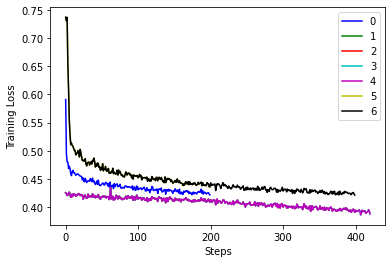

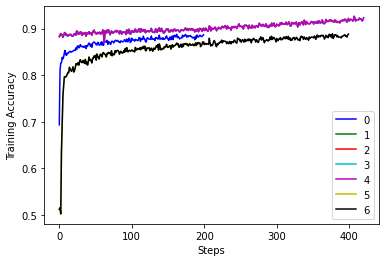

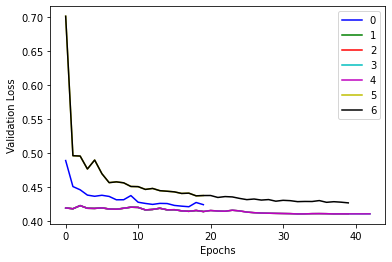

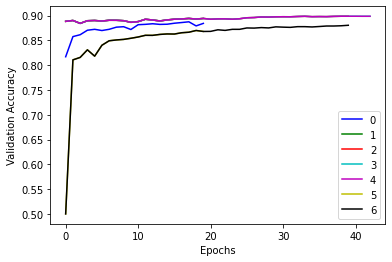

In [14]:
# Code to generate Plots from File
import matplotlib.pyplot as plt

file_paths = os.listdir('./results/')
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

file_paths_train = [file_name for file_name in file_paths if 'train' in file_name]
file_paths_validation = [file_name for file_name in file_paths if 'validation' in file_name]

# Train Loss Accuracy Load Data
train_losses = []
train_accuracies = []
for file_index in range(min(len(file_paths_train), len(colors))):
  train_loss = []
  train_accuracy = []
  file_name = file_paths_train[file_index]
  f = open('./results/{}'.format(file_name))
  lines = f.readlines()
  for line in lines:
    step, current_loss, current_accuracy = line.split(' ')
    train_loss.append(float(current_loss))
    train_accuracy.append(float(current_accuracy))
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  
# Train Loss Plot Data
for idx, train_loss in enumerate(train_losses):
  plt.plot(train_loss, colors[idx], label=idx)

plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# Train Accuracy Plot Data
for idx, train_accuracy in enumerate(train_accuracies):
  plt.plot(train_accuracy, colors[idx], label=idx)

plt.xlabel('Steps')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

# Train Loss Accuracy Load Data
val_losses = []
val_accuracies = []
for file_index in range(min(len(file_paths_validation), len(colors))):
  val_loss = []
  val_accuracy = []
  file_name = file_paths_validation[file_index]
  f = open('./results/{}'.format(file_name))
  lines = f.readlines()
  for line in lines:
    step, current_loss, current_accuracy = line.split(' ')
    val_loss.append(float(current_loss))
    val_accuracy.append(float(current_accuracy))
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  
# Validation Loss Plot Data
for idx, val_loss in enumerate(val_losses):
  plt.plot(val_loss, colors[idx], label=idx)

plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Validation Accuracy Plot Data
for idx, val_accuracy in enumerate(val_accuracies):
  plt.plot(val_accuracy, colors[idx], label=idx)

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

# Check How Many Duplicated Sentences we have

In [15]:
positive_data = []
with open(DATASET_FILE_TRAIN_POS, "r") as f:
  for x in f:
    positive_data.append(x)

negative_data = []
with open(DATASET_FILE_TRAIN_NEG, "r") as f:
  for x in f:
    negative_data.append(x)

print(len(positive_data))
positive_data = list(dict.fromkeys(positive_data))
print(len(positive_data))

print(len(negative_data))
negative_data = list(dict.fromkeys(negative_data))
print(len(negative_data))

1250000
1127644
1250000
1142838


## Preprocess test-set

In [16]:
test_data = []
with open(DATASET_FILE_TEST, "r") as f:
  for x in f:
    test_data.append(x)

encoded_test_data = []
for x in test_data:
  result, _ = pre_process_positive(tf.convert_to_tensor(x), 128)
  encoded_test_data.append(tf.reshape(tf.convert_to_tensor(result), (1,128)))
encoded_test_ds = tf.data.Dataset.from_tensor_slices(encoded_test_data)

## Predict test set

In [17]:
#model.load_weights(reload_checkpoint)
results = model.predict(encoded_test_ds)
labels = np.argmax(results, axis=1)

## Postprocessing

In [18]:
labels = [1 if x == 1 else -1 for x in labels]

#reverse labels
# labels = [-1 if x == 1 else 1 for x in labels]
#un-reverse labels
# labels = [1 if x == -1 else -1 for x in labels]

In [19]:
df = pd.DataFrame({'Id': np.arange(1,10001),
                  'Prediction': labels
                   })
df.to_csv(MODEL+identifier+'.csv', index=False)

In [20]:
MODEL+identifier

'albert_base'